# Getting Started with FLORIS v3

FLORIS is a command-line program written in Python. There are two primary packages that make up the software:
- `floris.simulation`: simulation framework including wake model definitions
- `floris.tools`: utilities for pre and post processing as well as driving the simulation

<!-- TODO add chart  -->

Users of FLORIS will develop a Python script with the following sequence of steps:

1. Load inputs and preprocess data
2. Run the wind farm wake simulation
3. Extract data and postprocess results

Generally, users will only interact with `floris.tools` and most often through
the `FlorisInterface` class. Additionally, `floris.tools` contains functionality
for comparing results, creating visualizations, and developing optimization cases. 

**NOTE `floris.tools` is under active design and development. The API's will change and additional functionality from FLORIS v2 will be included in upcoming releases.**

This notebook steps through the basic ideas and operations of FLORIS while showing
realistic uses and expected behavior.

## Initialize FlorisInterface

The `FlorisInterface` provides functionality to build a wind farm representation and drive
the simulation. This object is created (instantiated) by passing the path to a FLORIS input
file as the only argument. After this object is created, it can immediately be used to
inspect the data.

In [2]:
import numpy as np
from floris.tools import FlorisInterface
import matplotlib.pyplot as plt

fi = FlorisInterface("inputs/gch.yaml")
x, y = fi.get_turbine_layout()

print("     x       y")
for _x, _y in zip(x, y):
    print(f"{_x:6.1f}, {_y:6.1f}")

     x       y
   0.0,    0.0
 630.0,    0.0
1260.0,    0.0


## Build the model

At this point, FLORIS has been initialized with the data defined in the input file.
However, it is often simpler to define a basic configuration in the input file as
a starting point and then make modifications in the Python script. This allows for
generating data algorithmically or loading data from a data file. Modifications to
the wind farm representation are handled through the `FlorisInterface.reinitialize()`
function with keyword arguments. Another way to think of this function is that it
changes the value of inputs specified in the input file.

Let's change the location of turbines in the wind farm. The code below changes the
initial 3x1 layout to a 2x2 rectangular layout.

In [3]:
x_2x2 = [0, 0, 800, 800]
y_2x2 = [0, 400, 0, 400]
fi.reinitialize( layout=(x_2x2, y_2x2) )

x, y = fi.get_turbine_layout()

print("     x       y")
for _x, _y in zip(x, y):
    print(f"{_x:6.1f}, {_y:6.1f}")

     x       y
   0.0,    0.0
   0.0,  400.0
 800.0,    0.0
 800.0,  400.0


Additionally, we can change the wind speeds and wind directions.
These are lists of wind speeds and wind directions that will be
combined so that a wake calculation will happen for every wind
direction with each speed.

Notice that we can give `FlorisInterface.reinitialize()` multiple keyword arguments at once.

In [4]:
# One wind direction and one speed -> one atmospheric condition
fi.reinitialize( wind_directions=[270.0], wind_speeds=[8.0] )

# Two wind directions and one speed -> two atmospheric conditions
fi.reinitialize( wind_directions=[270.0, 280.0], wind_speeds=[8.0] )

# Two wind directions and two speeds -> four atmospheric conditions
fi.reinitialize( wind_directions=[270.0, 280.0], wind_speeds=[8.0, 9.0] )

`FlorisInterface.reinitialize()` creates all of the basic data structures required
for the simulation but it does not do any aerodynamic calculations. The low level
data structures have a complex shape that enables faster computations. Specifically,
most data is structured as a many-dimensional Numpy array with the following dimensions:

```python
np.array(
    (
        wind directions,
        wind speeds,
        turbines,
        grid-1,
        grid-2
    )
)
```

For example, we can see the shape of the data structure for the grid point x-coordinates
for the all turbines and get the x-coordinates of grid points for the third turbine in
the first wind direction and first wind speed. We can also plot all the grid points in
space to get an idea of the overall form of our grid.

Dimensions of grid x-components
(2, 2, 4, 3, 3)

Turbine 3 grid x-components for first wind direction and first wind speed
[[800. 800. 800.]
 [800. 800. 800.]
 [800. 800. 800.]]


(0.0, 150.0)

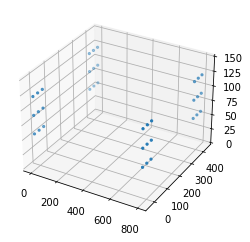

In [5]:
print("Dimensions of grid x-components")
print( np.shape(fi.floris.grid.x) )

print()
print("Turbine 3 grid x-components for first wind direction and first wind speed")
print(fi.floris.grid.x[0, 0, 2, :, :])

x = fi.floris.grid.x[0, 0, :, :, :]
y = fi.floris.grid.y[0, 0, :, :, :]
z = fi.floris.grid.z[0, 0, :, :, :]

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x, y, z, marker=".")
ax.set_zlim([0, 150])

## Execute wake calculation

Running the wake calculation is a one-liner. This will calculate the velocities
at each turbine given the wake of other turbines for every wind speed and wind
direction combination. Since we have not explicitly specified yaw control settings,
all turbines are aligned with the inflow.

In [6]:
fi.calculate_wake()

## Get turbine power

At this point, the simulation has completed and we can use the `FlorisInterface` to
extract useful information such as the power produced at each turbine. Remember that
we have configured the simulation with two wind directions, two wind speeds, and four
turbines.

In [7]:
powers = fi.get_turbine_powers() / 1000.0  # calculated in Watts, so convert to kW

print("Dimensions of `powers`")
print( np.shape(powers) )

N_TURBINES = fi.floris.farm.n_turbines

print()
print("Turbine powers for 8 m/s")
for i in range(2):
    print(f"Wind direction {i}")
    for j in range(N_TURBINES):
        print(f"  Turbine {j} - {powers[i, 0, j]:.2f} kW")
    print()

print("Turbine powers for all turbines at all wind conditions")
print(powers)

Dimensions of `powers`
(2, 2, 4)

Turbine powers for 8 m/s
Wind direction 0
  Turbine 0 - 1691.33 kW
  Turbine 1 - 1691.33 kW
  Turbine 2 - 591.00 kW
  Turbine 3 - 591.00 kW

Wind direction 1
  Turbine 0 - 1691.33 kW
  Turbine 1 - 1691.33 kW
  Turbine 2 - 1629.94 kW
  Turbine 3 - 1629.94 kW

Turbine powers for all turbines at all wind conditions
[[[1691.32664838 1691.32664838  591.00000224  591.00000224]
  [2407.84167188 2407.84167188  859.14143354  859.14143354]]

 [[1691.32664838 1691.32664838 1629.93914443 1629.93963935]
  [2407.84167188 2407.84167188 2319.79555096 2319.79625405]]]


## Applying yaw angles

Yaw angles are applied to turbines through the `FlorisInterface.calculate_wake` function.
In order to fit into the vectorized framework, the yaw settings must be represented as
a `Numpy.array` with  dimensions equal to:
- 0: number of wind directions
- 1: number of wind speeds
- 2: number of turbines

**Unlike the data configured in `FlorisInterface.reinitialize()`, yaw angles are not retained**
**in memory and must be provided each time `FlorisInterface.calculate_wake` is used.**
**If no yaw angles are given, all turbines will be aligned with the inflow.**

It is typically easiest to start with an array of 0's and modify individual
turbine yaw settings, as shown below.

In [8]:
yaw_angles = np.zeros( (2, 2, 4) )
print("Yaw angle array initialized with 0's")
print(yaw_angles)

print("First turbine yawed 25 degrees for every atmospheric condition")
yaw_angles[:, :, 0] = 25
print(yaw_angles)

fi.calculate_wake( yaw_angles=yaw_angles )

Yaw angle array initialized with 0's
[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]]]
First turbine yawed 25 degrees for every atmospheric condition
[[[25.  0.  0.  0.]
  [25.  0.  0.  0.]]

 [[25.  0.  0.  0.]
  [25.  0.  0.  0.]]]


## Start to finish

Let's put it all together. The code below outlines these steps:
1. Load an input file
2. Modify the inputs with a more complex wind turbine layout and additional atmospheric conditions
3. Calculate the velocities at each turbine for all atmospheric conditions
4. Get the total farm power
5. Develop the yaw control settings
6. Calculate the velocities at each turbine for all atmospheric conditions with the new yaw settings
7. Get the total farm power
8. Compare farm power with and without wake steering

In [29]:
# 1. Load an input file
fi = FlorisInterface("inputs/gch.yaml")

fi.floris.solver

# 2. Modify the inputs with a more complex wind turbine layout
D = 126.0  # Design the layout based on turbine diameter
x = [0, 0,  6 * D, 6 * D]
y = [0, 3 * D, 0, 3 * D]
# x = [0, 6 * D]
# y = [0, 3 * D]
# wind_directions = [270.0, 280.0]
wind_directions = [270.0]
wind_speeds = [8.0]

# Pass the new data to FlorisInterface
fi.reinitialize(
    layout=(x, y),
    wind_directions=wind_directions,
    wind_speeds=wind_speeds
)

# 3. Calculate the velocities at each turbine for all atmospheric conditions
# All turbines have 0 degrees yaw
fi.calculate_wake()

# 4. Get the total farm power
turbine_powers_baseline = fi.get_turbine_powers() / 1000.0  # Given in W, so convert to kW
farm_power_baseline = np.sum(turbine_powers_baseline, 2)  # Sum over the third dimension

In [30]:
# from floris.tools.optimization.yaw_optimization.yaw_optimizer_sr import (
#     YawOptimizationSR,
# )
# # Initialize optimizer object and run optimization using the Serial-Refine method
# yaw_opt = YawOptimizationSR(fi)#, exploit_layout_symmetry=False)
# df_opt = yaw_opt.optimize()

# print("Optimization results:")
# print(df_opt)

In [31]:
# 5. Develop the yaw control settings
# yaw_angles = np.zeros( (1, 1, 3) )  # Construct the yaw array with dimensions for two wind directions, one wind speed, and four turbines
# yaw_angles[0, :, 0] = 25            # At 270 degrees, yaw the first turbine 25 degrees
# yaw_angles[0, :, 1] = 25            # At 270 degrees, yaw the second turbine 25 degrees
yaw_angles = np.zeros( (1, 1, 4) )  # Construct the yaw array with dimensions for two wind directions, one wind speed, and four turbines
yaw_angles[0, :, 0] = 25            # At 270 degrees, yaw the first turbine 25 degrees
yaw_angles[0, :, 1] = 25            # At 270 degrees, yaw the second turbine 25 degrees

# 6. Calculate the velocities at each turbine for all atmospheric conditions with the new yaw settings
fi.calculate_wake( yaw_angles=yaw_angles )

# 7. Get the total farm power
turbine_powers_yaw = fi.get_turbine_powers() / 1000.0
farm_power_yaw = np.sum(turbine_powers_yaw, 2)

# 8. Compare farm power with and without wake steering
difference = 100 * (farm_power_yaw - farm_power_baseline) / farm_power_baseline
print("Power % difference with yaw")
print(f"    270 degrees: {difference[0, 0]:4.2f}%")
# print(f"    280 degrees: {difference[1, 0]:4.2f}%")
# print(f"    280 degrees: {difference[0, 0]:4.2f}%")

Power % difference with yaw
    270 degrees: 4.00%


In [32]:
turbine_powers_yaw, farm_power_yaw

(array([[[1405.86360762, 1405.86360762,  925.27154834,  925.27154834]]]),
 array([[4662.27031191]]))

In [33]:
fi.floris.flow_field.u

array([[[[[7.59695563, 8.        , 8.29335086],
          [7.59695563, 8.        , 8.29335086],
          [7.59695563, 8.        , 8.29335086]],

         [[7.59695563, 8.        , 8.29335086],
          [7.59695563, 8.        , 8.29335086],
          [7.59695563, 8.        , 8.29335086]],

         [[5.50267027, 5.27937951, 6.00708724],
          [6.21089001, 6.19940559, 6.78022784],
          [7.0419436 , 7.27900127, 7.68746218]],

         [[5.50267027, 5.27937951, 6.00708724],
          [6.21089001, 6.19940559, 6.78022784],
          [7.0419436 , 7.27900127, 7.68746218]]]]])

In [34]:
# 5. Develop the yaw control settings
yaw_angles = np.zeros( (1, 1, 4) )  # Construct the yaw array with dimensions for two wind directions, one wind speed, and four turbines
yaw_angles[0, :, 0] = 10            # At 270 degrees, yaw the first turbine 25 degrees
yaw_angles[0, :, 1] = 10            # At 270 degrees, yaw the second turbine 25 degrees
# yaw_angles[1, :, 0] = 10           # At 265 degrees, yaw the first turbine -25 degrees
# yaw_angles[1, :, 1] = 10           # At 265 degrees, yaw the second turbine -25 degrees
# yaw_angles = np.zeros( (1, 1, 4) )  # Construct the yaw array with dimensions for two wind directions, one wind speed, and four turbines
# yaw_angles[0, :, 0] = 10           # At 280 degrees, yaw the first turbine -25 degrees
# yaw_angles[0, :, 1] = 10           # At 280 degrees, yaw the second turbine -25 degrees

# 6. Calculate the velocities at each turbine for all atmospheric conditions with the new yaw settings
fi.calculate_wake( yaw_angles=yaw_angles )

# 7. Get the total farm power
turbine_powers_yaw = fi.get_turbine_powers() / 1000.0
farm_power_yaw = np.sum(turbine_powers_yaw, 2)

# 8. Compare farm power with and without wake steering
difference = 100 * (farm_power_yaw - farm_power_baseline) / farm_power_baseline
print("Power % difference with yaw")
print(f"    270 degrees: {difference[0, 0]:4.2f}%")
# print(f"    280 degrees: {difference[1, 0]:4.2f}%")
# print(f"    280 degrees: {difference[0, 0]:4.2f}%")

Power % difference with yaw
    270 degrees: 1.46%


In [35]:
turbine_powers_yaw

array([[[1645.70558075, 1645.70558075,  628.48412631,  628.48412631]]])

In [36]:
farm_power_yaw

array([[4548.37941413]])

In [37]:
fi.floris.flow_field.u

array([[[[[7.59695563, 8.        , 8.29335086],
          [7.59695563, 8.        , 8.29335086],
          [7.59695563, 8.        , 8.29335086]],

         [[7.59695563, 8.        , 8.29335086],
          [7.59695563, 8.        , 8.29335086],
          [7.59695563, 8.        , 8.29335086]],

         [[5.25210682, 4.95198295, 5.73355523],
          [5.3595432 , 5.09163712, 5.85084005],
          [6.21254865, 6.20044002, 6.78203852]],

         [[5.25210682, 4.95198295, 5.73355523],
          [5.3595432 , 5.09163712, 5.85084005],
          [6.21254865, 6.20044002, 6.78203852]]]]])

## Visualization

While comparing turbine and farm powers is meaningful, a picture is worth at least
1000 Watts, and the `FlorisInterface` provides powerful routines for visualization.

**NOTE `floris.tools` is under active design and development. The API's will change and additional functionality from FLORIS v2 will be included in upcoming releases.**

The visualization functions require that the user select a single atmospheric condition
to plot. The internal data structures still have the same shape but the wind speed and
wind direction dimensions have a size of 1. This means that the yaw angle array used
for plotting must have the same shape as above but a single atmospheric condition must
be selected.

Let's create a horizontal slice of each atmospheric condition from above with and without
yaw settings included. Notice that although we are plotting the conditions for two
different wind directions, the farm is rotated so that the wind is coming from the
left (West) in both cases.

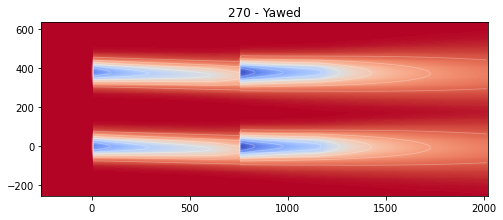

In [41]:
from floris.tools.visualization import visualize_cut_plane

# fig, axarr = plt.subplots(1, 2, figsize=(15,8))
fig, axarr = plt.subplots(1, 1, figsize=(8,8))

# horizontal_plane = fi.calculate_horizontal_plane( wd=[wind_directions[0]], height=90.0 )
# visualize_cut_plane(horizontal_plane, ax=axarr[0], title="270 - Aligned")

horizontal_plane = fi.calculate_horizontal_plane( wd=[wind_directions[0]], yaw_angles=yaw_angles[0:1,0:1] , height=90.0 )
visualize_cut_plane(horizontal_plane, ax=axarr, title="270 - Yawed")
# visualize_cut_plane(horizontal_plane, ax=axarr[1], title="270 - Yawed")

# fig, axarr = plt.subplots(2, 2, figsize=(15,8))

# horizontal_plane = fi.calculate_horizontal_plane( wd=[wind_directions[0]], height=90.0 )
# visualize_cut_plane(horizontal_plane, ax=axarr[0,0], title="270 - Aligned")

# horizontal_plane = fi.calculate_horizontal_plane( wd=[wind_directions[0]], yaw_angles=yaw_angles[0:1,0:1] , height=90.0 )
# visualize_cut_plane(horizontal_plane, ax=axarr[0,1], title="270 - Yawed")

# horizontal_plane = fi.calculate_horizontal_plane( wd=[wind_directions[1]], height=90.0 )
# visualize_cut_plane(horizontal_plane, ax=axarr[1,0], title="280 - Aligned")

# horizontal_plane = fi.calculate_horizontal_plane( wd=[wind_directions[1]], yaw_angles=yaw_angles[1:2,0:1] , height=90.0 )
# visualize_cut_plane(horizontal_plane, ax=axarr[1,1], title="280 - Yawed")

We can also plot the streamwise inflow velocities on the turbine rotor
grid points located on the rotor plane. The `plot_rotor_values` function
simply plots any data given as the first argument, so in this case
`fi.floris.flow_field.u` contains the yawed calculation from above.

In [30]:
from floris.tools.visualization import plot_rotor_values

Text(0.5, 0.98, 'Wind direction 270')

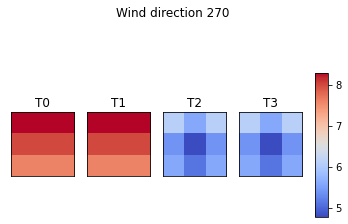

In [36]:
yaw_angles = np.zeros( (1, 1, 4) )  # Construct the yaw array with dimensions for two wind directions, one wind speed, and four turbines
fi.reinitialize(
    layout=(x, y),
    wind_directions=wind_directions,
    wind_speeds=wind_speeds
)
fi.calculate_wake( yaw_angles=yaw_angles )
fi.get_turbine_powers() / 1000.0
fig, _, _ , _ = plot_rotor_values(fi.floris.flow_field.u, wd_index=0, ws_index=0, n_rows=1, n_cols=4, return_fig_objects=True)
fig.suptitle("Wind direction 270")

In [37]:
fi.floris.flow_field.u.shape

(1, 1, 4, 3, 3)

In [38]:
fi.floris.flow_field.u

array([[[[[7.59695563, 8.        , 8.29335086],
          [7.59695563, 8.        , 8.29335086],
          [7.59695563, 8.        , 8.29335086]],

         [[7.59695563, 8.        , 8.29335086],
          [7.59695563, 8.        , 8.29335086],
          [7.59695563, 8.        , 8.29335086]],

         [[5.59051554, 5.39221868, 6.10298508],
          [5.12055575, 4.78140933, 5.58994518],
          [5.59051554, 5.39221868, 6.10298508]],

         [[5.59051554, 5.39221868, 6.10298508],
          [5.12055575, 4.78140933, 5.58994518],
          [5.59051554, 5.39221868, 6.10298508]]]]])

Text(0.5, 0.98, 'Wind direction 280')

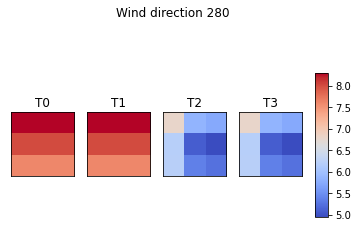

In [34]:
yaw_angles = np.zeros( (1, 1, 4) )  # Construct the yaw array with dimensions for two wind directions, one wind speed, and four turbines
yaw_angles[0, :, 0] = 10           # At 280 degrees, yaw the first turbine -25 degrees
yaw_angles[0, :, 1] = 10           # At 280 degrees, yaw the second turbine -25 degrees

fi.calculate_wake( yaw_angles=yaw_angles )
fi.get_turbine_powers() / 1000.0

fig, _, _ , _ = plot_rotor_values(fi.floris.flow_field.u, wd_index=0, ws_index=0, n_rows=1, n_cols=4, return_fig_objects=True)
fig.suptitle("Wind direction 280")

# fig, _, _ , _ = plot_rotor_values(fi.floris.flow_field.u, wd_index=0, ws_index=0, n_rows=1, n_cols=4, return_fig_objects=True)
# fig.suptitle("Wind direction 270")

# fig, _, _ , _ = plot_rotor_values(fi.floris.flow_field.u, wd_index=1, ws_index=0, n_rows=1, n_cols=4, return_fig_objects=True)
# fig.suptitle("Wind direction 280")

In [35]:
np.array(fi.floris.farm.turbine_definitions[0]['power_thrust_table']['wind_speed'])

array([ 0.  ,  2.  ,  2.5 ,  3.  ,  3.5 ,  4.  ,  4.5 ,  5.  ,  5.5 ,
        6.  ,  6.5 ,  7.  ,  7.5 ,  8.  ,  8.5 ,  9.  ,  9.5 , 10.  ,
       10.5 , 11.  , 11.5 , 12.  , 12.5 , 13.  , 13.5 , 14.  , 14.5 ,
       15.  , 15.5 , 16.  , 16.5 , 17.  , 17.5 , 18.  , 18.5 , 19.  ,
       19.5 , 20.  , 20.5 , 21.  , 21.5 , 22.  , 22.5 , 23.  , 23.5 ,
       24.  , 24.5 , 25.  , 25.01, 25.02, 50.  ])

In [ ]:
fi.floris.flow_field.u

## On Grid Points

In FLORIS, grid points are the points in space where the wind conditions are calculated.
In a typical simulation, these are all located on a regular grid on each turbine rotor.

The parameter `turbine_grid_points` specifies the number of rows and columns which define the turbine grid.
In the example inputs, this value is 3 meaning there are 3 x 3 = 9 total grid points for each turbine.
Wake steering codes currently require greater values greater than 1 in order to compute gradients.
However, a single grid point (1 x 1) may be suitable for non wind farm control applications,
but retuning of some parameters might be required.

We can visualize the locations of the grid points in the current example using `matplotlib.pyplot`.

In [ ]:
# Get the grid points
xs = fi.floris.grid.x
ys = fi.floris.grid.y
zs = fi.floris.grid.z

# Consider the shape
print(f"shape of xs: {xs.shape}")
print("  2 wd x 2 ws x 4 turbines x 3 x 3 grid points")

# Lets plot just one wd/ws conditions
xs = xs[1, 0, :, :, :]
ys = ys[1, 0, :, :, :]
zs = zs[1, 0, :, :, :]

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(xs, ys, zs, marker=".")
ax.set_zlim([0, 150])

# Advanced Usage and Concepts

## Calculating AEP

Calculating AEP in FLORIS v3 leverages the vectorized framework to
substantially reduce the computation time with respect to v2.4.
Here, we demonstrate a simple AEP calculation for a 25-turbine farm
using several different modeling options. We make the assumption
that every wind speed and direction is equally likely. We also
report the time required for the computation using the Python
`time.perf_counter()` function.

In [ ]:
import time
from typing import Tuple

wind_directions = np.arange(0.0, 360.0, 5.0)
wind_speeds = np.arange(5.0, 25.0, 1.0)

num_bins = len(wind_directions) * len(wind_speeds)
print(f"Calculating AEP for {num_bins} wind direction and speed combinations...")

# Set up a square 25 turbine layout
N = 5  # Number of turbines per row and per column
D = 126.0

X, Y = np.meshgrid(
    7.0 * D * np.arange(0, N, 1),
    7.0 * D * np.arange(0, N, 1),
)
X = X.flatten()
Y = Y.flatten()
print(f"Number of turbines = {len(X)}")

# Define several models
fi_jensen = FlorisInterface("inputs/jensen.yaml")
fi_gch = FlorisInterface("inputs/gch.yaml")
fi_cc = FlorisInterface("inputs/cc.yaml")

# Assign the layouts, wind speeds and directions
fi_jensen.reinitialize(layout=(X, Y), wind_directions=wind_directions, wind_speeds=wind_speeds)
fi_gch.reinitialize(layout=(X, Y), wind_directions=wind_directions, wind_speeds=wind_speeds)
fi_cc.reinitialize(layout=(X, Y), wind_directions=wind_directions, wind_speeds=wind_speeds)

def time_model_calculation(model_fi: FlorisInterface) -> Tuple[float, float]:
    """
    This function performs the wake calculation for a given
    FlorisInterface object and computes the AEP while
    tracking the amount of wall-time required for both steps.

    Args:
        model_fi (FlorisInterface): _description_
        float (_type_): _description_

    Returns:
        tuple(float, float):
            0: AEP
            1: Wall-time for the computation
    """
    start = time.perf_counter()
    model_fi.calculate_wake()
    aep = model_fi.get_farm_power().sum() / num_bins  / 1E9 * 365 * 24
    end = time.perf_counter()
    return aep, end - start

jensen_aep, jensen_compute_time = time_model_calculation(fi_jensen)
gch_aep, gch_compute_time = time_model_calculation(fi_gch)
cc_aep, cc_compute_time = time_model_calculation(fi_cc)

print('Model    AEP (GWh)  Compute Time (s)')
print('{:8s} {:<10.3f} {:<6.3f}'.format("Jensen", jensen_aep, jensen_compute_time))
print('{:8s} {:<10.3f} {:<6.3f}'.format("GCH", gch_aep, gch_compute_time))
print('{:8s} {:<10.3f} {:<6.3f}'.format("CC", cc_aep, cc_compute_time))

## Wake Steering Design

FLORIS V3 further includes new optimization routines for the design of wake steering controllers.  The SerialRefine is a new method for quickly identifying optimum yaw angles.

In [ ]:
# Demonstrate on 7-turbine single row farm
X = np.linspace(0, 6*7*D, 7)
Y = np.zeros_like(X)
wind_speeds = [8.]
wind_directions = np.arange(0., 360., 2.)
fi_gch.reinitialize(layout=(X, Y), wind_directions=wind_directions, wind_speeds=wind_speeds)

In [ ]:
from floris.tools.optimization.yaw_optimization.yaw_optimizer_sr import YawOptimizationSR

# Define the SerialRefine optimization
yaw_opt = YawOptimizationSR(
    fi=fi_gch,
    minimum_yaw_angle=0.0,  # Allowable yaw angles lower bound
    maximum_yaw_angle=25.0,  # Allowable yaw angles upper bound
    Ny_passes=[5, 4],
    exclude_downstream_turbines=True,
    exploit_layout_symmetry=True,
)

In [ ]:
start = time.perf_counter()

## Calculate the optimum yaw angles for 25 turbines and 72 wind directions
df_opt = yaw_opt.optimize()

end = time.perf_counter()

walltime = end - start
print(f"Optimization wall time: {walltime:.3f} s")


In the results, T0 is the upstream turbine when wind direction is 270, while T6 is upstream at 90 deg

In [ ]:
# Show the results
yaw_angles_opt = np.vstack(df_opt["yaw_angles_opt"])
fig, axarr = plt.subplots(len(X), 1, sharex=True, sharey=True, figsize=(10, 10))
for i in range(len(X)):
    axarr[i].plot(wind_directions, yaw_angles_opt[:, i], 'k-', label='T%d' % i)
    axarr[i].set_ylabel('Yaw (Deg)')
    axarr[i].legend()
    axarr[i].grid(True)
axarr[-1].set_xlabel('Wind Direction (Deg)')